In [16]:
# Imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import folium
import json
import re
from collections import Counter
from scipy import stats
import geopandas as gpd


In [17]:
listings_filepath = '/Users/arneshsaha/Desktop/AirBnb/datasets/listings.csv'
listings_df = pd.read_csv(listings_filepath)

Data Cleaning

In [18]:
columns = ['host_url', 'host_name', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'calendar_updated', 'calendar_last_scraped', 'picture_url', 
           'neighbourhood_group_cleansed', 'license', 'host_location', 'first_review', 'last_review', 'host_thumbnail_url', 
           'host_picture_url', 'description', 'neighborhood_overview', 'host_since', 'host_about', 'host_neighbourhood', 'host_verifications', 'neighbourhood',
           'reviews_per_month', 'bathrooms', 'bathrooms_text',  'host_response_time', 'property_type', 'id',
           'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
           'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', "calculated_host_listings_count_shared_rooms"]
listings_df.drop(columns=columns, inplace=True)

# listings_df.dropna(subset=['bedrooms', 'review_scores_cleanliness',
#                    "beds"], inplace=True)

# Converting columns with (True, False) to (1, 0)
replace_dict = {'instant_bookable': {'t': 1, 'f': 0},
                'has_availability': {'t': 1, 'f': 0}
                }
listings_df = listings_df.replace(replace_dict)

# Creating parking column and assigning the rows with parking feature
parking_rows = listings_df[(listings_df['name'].str.contains('parking', case=False)) |
                           (listings_df['amenities'].apply(lambda x: 'parking' in x))]

listings_df['Parking'] = 0
listings_df.loc[parking_rows.index, 'Parking'] = 1

# Creating room_type_num column to store unique types in room_type
room_type_labels, room_type_unique = pd.factorize(listings_df['room_type'])
listings_df['room_type_num'] = room_type_labels

# Removing dollar sign from price
listings_df['price'] = listings_df['price'].str.replace(
    ',', '', regex=True).str.replace('$', '', regex=True).astype('float')

# drop further columns
columns = ['name', 'amenities', 'room_type_num']
listings_df.drop(columns=columns, inplace=True)

# Droping NaN
listings_df.dropna(axis=0, inplace=True)

# Resetting index to have sequential index

listings_df = listings_df.reset_index().sort_values(by='index')
listings_df = listings_df.drop(columns=['index'])
listings_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6711 entries, 0 to 6710
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighbourhood_cleansed       6711 non-null   object 
 1   latitude                     6711 non-null   float64
 2   longitude                    6711 non-null   float64
 3   room_type                    6711 non-null   object 
 4   accommodates                 6711 non-null   int64  
 5   price                        6711 non-null   float64
 6   minimum_nights               6711 non-null   int64  
 7   maximum_nights               6711 non-null   int64  
 8   minimum_minimum_nights       6711 non-null   int64  
 9   maximum_minimum_nights       6711 non-null   int64  
 10  minimum_maximum_nights       6711 non-null   int64  
 11  maximum_maximum_nights       6711 non-null   int64  
 12  minimum_nights_avg_ntm       6711 non-null   float64
 13  maximum_nights_avg

In [19]:
print("Original Shape:", listings_df.shape)
z_scores = np.abs(stats.zscore(listings_df['price']))

# Define a threshold for outlier removal (e.g., Z-score > 3)
threshold = 0.8

# Filter the dataframe to remove outliers
listings_df = listings_df[z_scores < threshold]

# Print the shape of the filtered dataframe

print("Filtered Shape:",   listings_df.shape)

Original Shape: (6711, 31)
Filtered Shape: (6617, 31)


In [20]:
listings_df.neighbourhood_cleansed.nunique()

111

In [21]:
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates']
listings_df

,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,Parking,price_per_person
0,"Old Town, Princes Street and Leith Street",55.95759,-3.18805,Entire home/apt,2,114.0,3,30,1,3,...,4.97,4.98,4.96,4.97,4.98,4.98,4.91,0,1,57.000000
1,"Old Town, Princes Street and Leith Street",55.94980,-3.18354,Entire home/apt,9,598.0,2,1000,28,300,...,4.38,4.32,4.40,4.69,4.72,4.94,4.09,1,1,66.444444
2,Polwarth,55.93692,-3.22414,Private room,3,60.0,1,14,1,4,...,4.82,4.86,4.81,4.95,4.97,4.73,4.79,0,1,20.000000
3,Dalry and Fountainbridge,55.94192,-3.21878,Entire home/apt,10,162.0,2,1125,2,5,...,4.74,4.81,4.80,4.84,4.81,4.71,4.70,1,1,16.200000
4,Deans Village,55.95324,-3.20368,Entire home/apt,4,138.0,2,30,2,4,...,4.96,4.95,4.96,4.93,4.96,4.96,4.86,1,1,34.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6706,Broughton South,55.96398,-3.18636,Private room,2,95.0,2,7,2,2,...,4.63,4.82,4.92,4.74,4.77,4.51,4.59,0,1,47.500000
6707,Comiston and Swanston,55.90923,-3.21368,Private room,2,40.0,2,31,2,2,...,4.86,4.85,4.88,4.92,4.92,4.62,4.74,0,1,20.000000
6708,Broughton South,55.96389,-3.18585,Entire home/apt,6,85.0,2,40,2,2,...,4.56,4.82,4.78,4.78,4.81,4.62,4.58,0,1,14.166667
6709,Willowbrae and Duddingston Village,55.95281,-3.14962,Entire home/apt,6,231.0,4,31,4,7,...,4.76,4.82,4.88,4.92,4.91,4.66,4.77,0,1,38.500000


In [22]:

import pandas as pd
import geopandas as gpd

# Read the CSV file into a pandas dataframe
neighbourhoods_df = pd.read_csv('/Users/arneshsaha/Desktop/AirBnb/datasets/neighbourhoods.csv')

# Create a geopandas dataframe with the geometry column
geometry = gpd.GeoSeries.from_wkt(neighbourhoods_df['geometry'])
neighbourhoods_gdf = gpd.GeoDataFrame(neighbourhoods_df, geometry=geometry)

# Plot the neighbourhoods
type(neighbourhoods_gdf.geometry)



geopandas.geoseries.GeoSeries

In [23]:


# Create a geopandas dataframe with the latitude and longitude columns
geometry = gpd.points_from_xy(listings_df.longitude, listings_df.latitude)
gdf = gpd.GeoDataFrame(listings_df, geometry=geometry)
# gdf

# Read the neighbourhoods data from a CSV file into a pandas dataframe
neighbourhoods_df = pd.read_csv('/Users/arneshsaha/Desktop/AirBnb/datasets/neighbourhoods.csv')
neighbourhoods_df.drop(columns=['neighbourhood_group'], inplace=True)
# Convert the geometry column to a GeoSeries object
geometry2 = gpd.GeoSeries.from_wkt(neighbourhoods_df['geometry'])

# Create a geopandas dataframe with the geometry column
neighbourhoods_gdf = gpd.GeoDataFrame(neighbourhoods_df, geometry=geometry2)
neighbourhoods_gdf

# Perform a spatial join to get the neighbourhoods for each Airbnb listing
merged = gpd.sjoin(gdf, neighbourhoods_gdf, op='within')
merged

# Calculate the average price for each neighbourhood
neighbourhood_prices = merged.groupby('neighbourhood')['price'].mean()
neighbourhood_availability_30 = merged.groupby('neighbourhood')['availability_30'].mean() 
neighbourhood_availability_365 = merged.groupby('neighbourhood')['availability_365'].mean()
neighborhood_counts = listings_df['neighbourhood_cleansed'].value_counts()
neighborhood_df = pd.DataFrame({'neighbourhood': neighborhood_counts.index, 'property_count': neighborhood_counts.values})
neighborhood_price_per_person = merged.groupby('neighbourhood')['price_per_person'].mean()



# Merge the average prices with the neighbourhoods geodataframe

merged_neighbourhoods = neighbourhoods_gdf.merge(neighborhood_price_per_person, on='neighbourhood')
merged_neighbourhoods = merged_neighbourhoods.merge(neighbourhood_prices, on='neighbourhood')
merged_neighbourhoods = merged_neighbourhoods.merge(neighbourhood_availability_30, on='neighbourhood')
merged_neighbourhoods = merged_neighbourhoods.merge(neighbourhood_availability_365, on='neighbourhood')
merged_neighbourhoods = pd.merge(merged_neighbourhoods, neighborhood_df, on='neighbourhood', how='left')


merged_neighbourhoods = merged_neighbourhoods.drop(merged_neighbourhoods.columns[0], axis=1)


merged_neighbourhoods


# # Plot the average prices for each neighbourhood
# fig, ax = plt.subplots(1,figsize=(10, 6))

# merged_neighbourhoods.plot(column='availability_365', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

# ax.set_title('Average Airbnb availability_365 by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# plt.show()


/Users/arneshsaha/miniforge3/envs/fds/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,neighbourhood,geometry,price_per_person,price,availability_30,availability_365,property_count
0,Balerno and Bonnington Village,"MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...",38.688095,109.571429,9.857143,202.071429,14
1,Currie West,"MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...",27.125000,58.125000,9.125000,183.750000,8
2,Currie East,"MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...",35.011905,85.000000,12.714286,166.000000,7
3,Baberton and Juniper Green,"MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...",32.000000,77.714286,4.857143,101.142857,7
4,Bonaly and The Pentlands,"MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...",29.779412,92.058824,7.764706,143.941176,17
...,...,...,...,...,...,...,...
106,South Gyle,"MULTIPOLYGON (((-3.30084 55.94246, -3.30081 55...",31.909375,107.125000,7.187500,72.437500,16
107,"Ratho, Ingliston and Gogar","MULTIPOLYGON (((-3.34287 55.96432, -3.34150 55...",39.489286,135.514286,11.828571,131.428571,35
108,Queensferry West,"MULTIPOLYGON (((-3.41600 55.99385, -3.41582 55...",33.203704,102.888889,4.555556,89.777778,9
109,"Dalmeny, Kirkliston and Newbridge","MULTIPOLYGON (((-3.29012 55.99545, -3.28998 55...",40.640351,133.736842,10.894737,165.315789,19


average prices for each neighbourhood

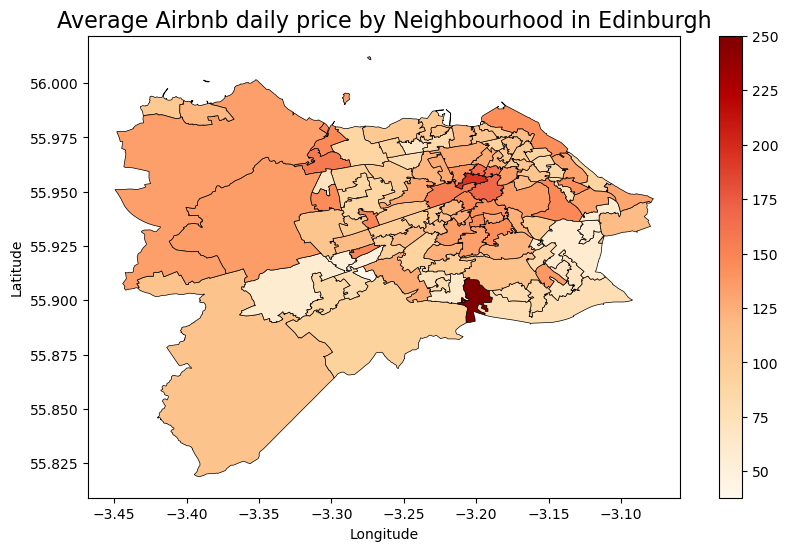

In [24]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='price', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb daily price by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


average availability_30 for each neighbourhood

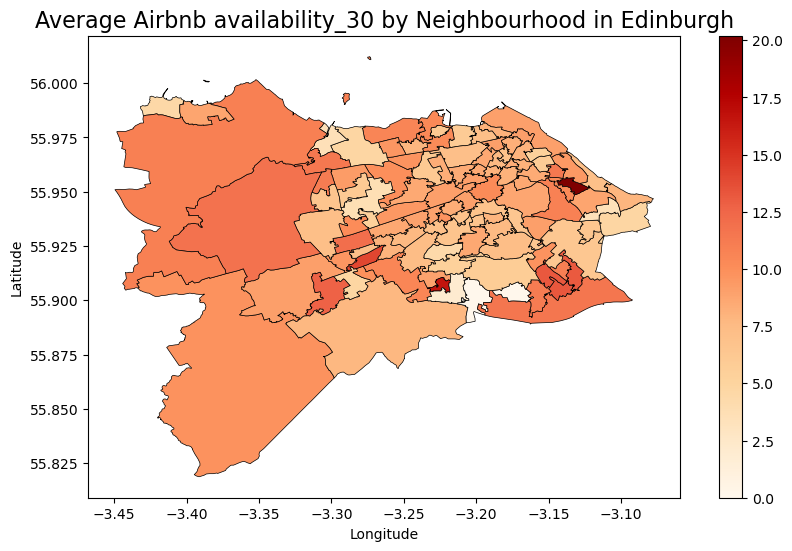

In [25]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='availability_30', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb availability_30 by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


average availability_365 for each neighbourhood

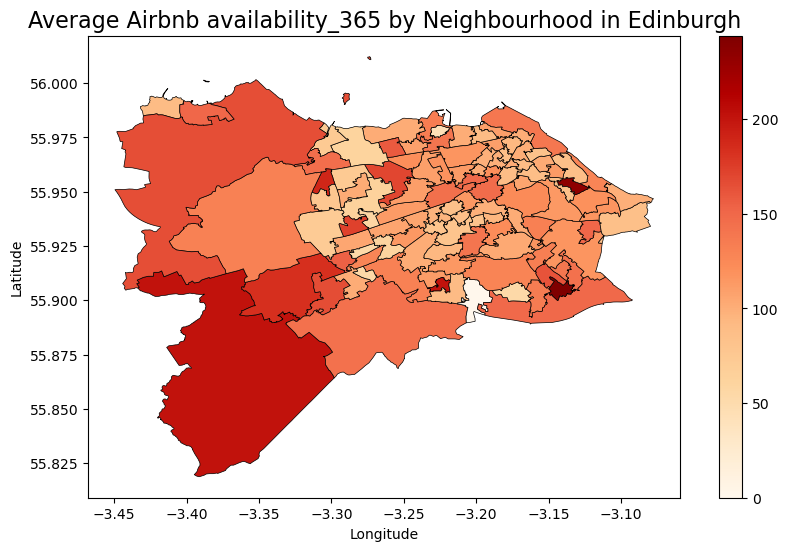

In [26]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='availability_365', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb availability_365 by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


Number of listings in each neighbourhood

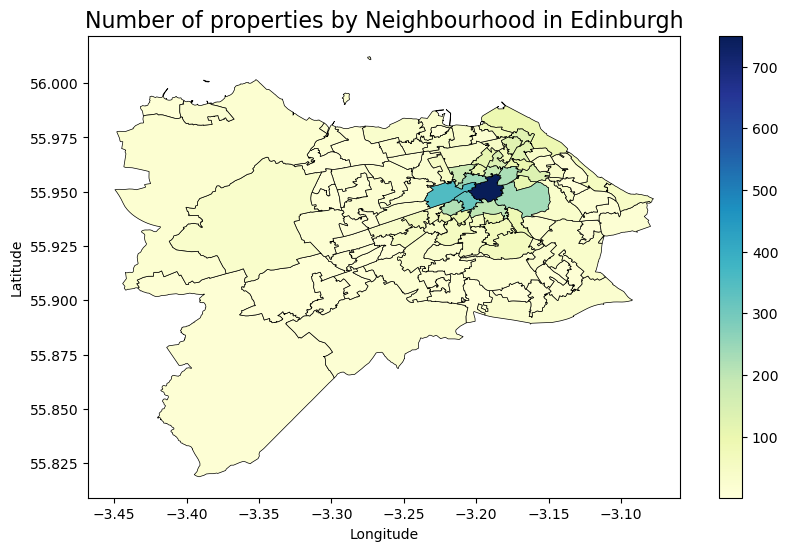

In [27]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

# Using the YlGnBu colormap
merged_neighbourhoods.plot(column='property_count', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black', linewidth=0.5, aspect=1.5)

ax.set_title('Number of properties by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


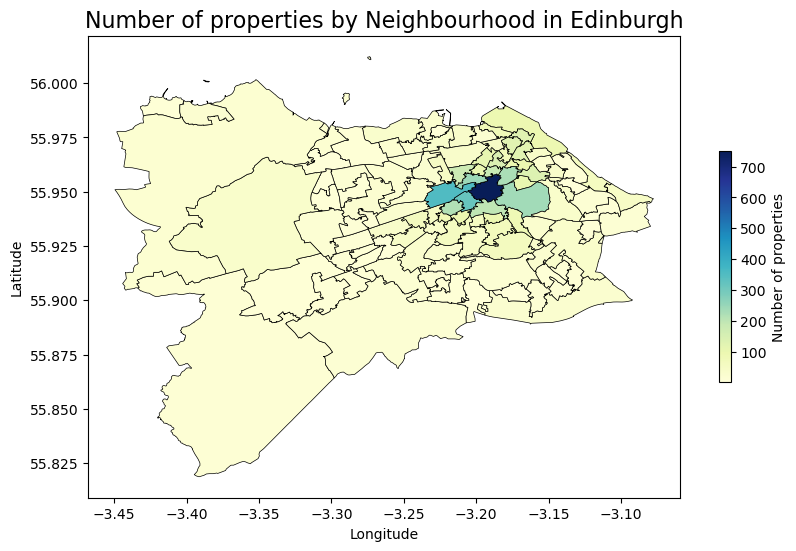

In [28]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1, figsize=(10, 6))

# Extract the minimum and maximum values of the property_count column
vmin = merged_neighbourhoods['property_count'].min()
vmax = merged_neighbourhoods['property_count'].max()

# Plot the data with the YlGnBu colormap and include the minimum and maximum values in the legend
merged_neighbourhoods.plot(column='property_count', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black', linewidth=0.5, aspect=1.5, vmin=vmin, vmax=vmax, legend_kwds={'label': "Number of properties", 'orientation': "vertical", 'shrink': 0.5, 'pad': 0.05})

# Set the title and axis labels
ax.set_title('Number of properties by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Get the colorbar object and set the font size of the labels
cbar = ax.get_figure().get_axes()[1]


plt.show()


Average price per person by neighbourhood

Text(88.71623148883445, 0.5, 'Latitude')

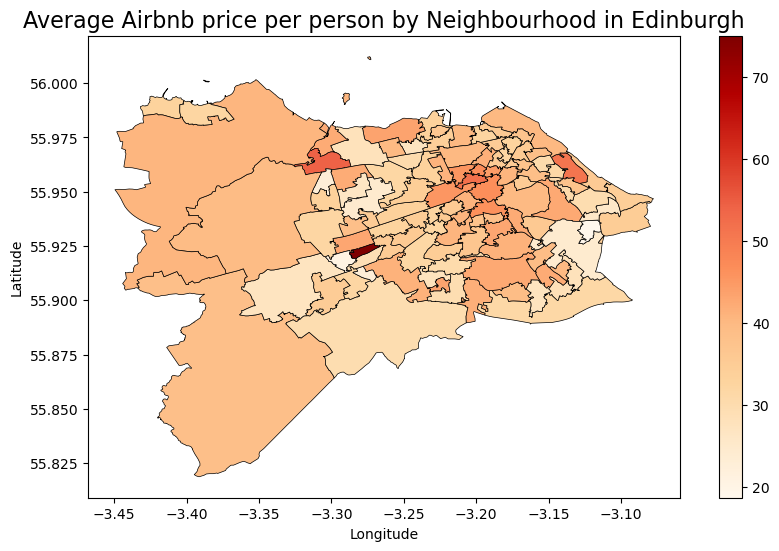

In [29]:
# Plot the average prices for each neighbourhood
fig, ax = plt.subplots(1,figsize=(10, 6))

merged_neighbourhoods.plot(column='price_per_person', ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.5, aspect = 1.5)

ax.set_title('Average Airbnb price per person by Neighbourhood in Edinburgh', fontdict={'fontsize': 16})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

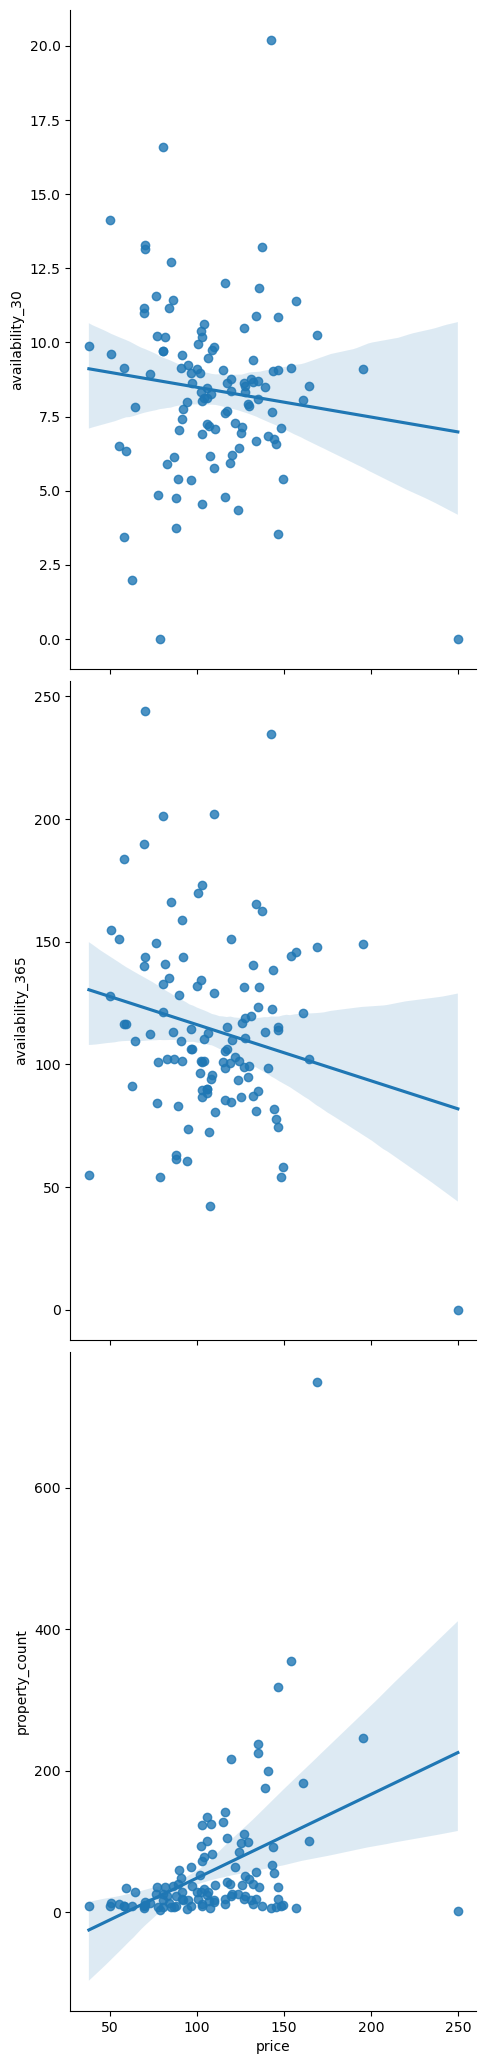

In [30]:
sns.pairplot(merged_neighbourhoods, x_vars=['price'], y_vars=['availability_30', 'availability_365', 'property_count'], height=7, aspect=0.7, kind='reg')